In [1]:
import pandas as pd
import numpy as np
import os
import requests
import zipfile
from datetime import datetime
#import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
import statsmodels.formula.api as smf
import urllib
import matplotlib.cm as cm
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)
%matplotlib inline
#by year, bourough
#predict far not area
#change the labels of landuse category
#remove variables for the corr graph
#simple regression for some paired variables 

In [2]:
data = pd.read_csv('master2_2010_2017.csv')
data.head()

,Unnamed: 0,bbl,geoid,year_x,borough,lot,cd,zipcode,zonedist1,zonedist2,...,income_pc,housing_units,geometry,subway_acc,subway,subway_scale,%low_educ,noisePerCapita,tractid,built_green
0,0,2.025830e+09,360050019004,2010,BX,2,201,0,M3-1,NaN,...,0.0,0.0,POINT (-73.91419443859854 40.79864859514597),7720.114746,0.300386,0.300386,NaN,0.0,36005001900,0.158909
1,1,2.025430e+09,360050019004,2010,BX,1,201,10454,M3-1,M2-1,...,0.0,0.0,POINT (-73.91862272941451 40.80038462661332),7720.114746,0.300386,0.300386,NaN,0.0,36005001900,0.158909
2,2,2.022600e+09,360050019004,2010,BX,100,201,10454,M3-1,NaN,...,0.0,0.0,POINT (-73.92942328763192 40.80654795473313),7720.114746,0.300386,0.300386,NaN,0.0,36005001900,0.158909
3,3,2.025831e+09,360050019004,2010,BX,650,201,0,M3-1,NaN,...,0.0,0.0,POINT (-73.91292003032608 40.79693680826438),7720.114746,0.300386,0.300386,NaN,0.0,36005001900,0.158909
4,4,2.025830e+09,360050019004,2010,BX,365,201,10454,M3-1,NaN,...,0.0,0.0,POINT (-73.90968640545535 40.79845007926411),7720.114746,0.300386,0.300386,NaN,0.0,36005001900,0.158909


In [3]:
data.columns

Index(['Unnamed: 0', 'bbl', 'geoid', 'year_x', 'borough', 'lot', 'cd',
       'zipcode', 'zonedist1', 'zonedist2', 'zonedist3', 'zonedist4',
       'overlay1', 'overlay2', 'spdist1', 'spdist2', 'ltdheight', 'allzoning1',
       'allzoning2', 'splitzone', 'bldgclass', 'landuse', 'easements',
       'ownertype', 'lotarea', 'comarea', 'resarea', 'officearea',
       'retailarea', 'garagearea', 'strgearea', 'factryarea', 'lotfront',
       'lotdepth', 'otherarea', 'numbldgs', 'numfloors', 'unitsres',
       'lotfront.1', 'lotdepth.1', 'assessland', 'assesstot', 'yearbuilt',
       'builtfar', 'maxallwfar', 'residfar', 'commfar', 'facilfar', 'statefp',
       'countyfp', 'tractce', 'blkgrpce', 'med_income', 'population',
       'low_edu', 'income_pc', 'housing_units', 'geometry', 'subway_acc',
       'subway', 'subway_scale', '%low_educ', 'noisePerCapita', 'tractid',
       'built_green'],
      dtype='object')

<AxesSubplot:>

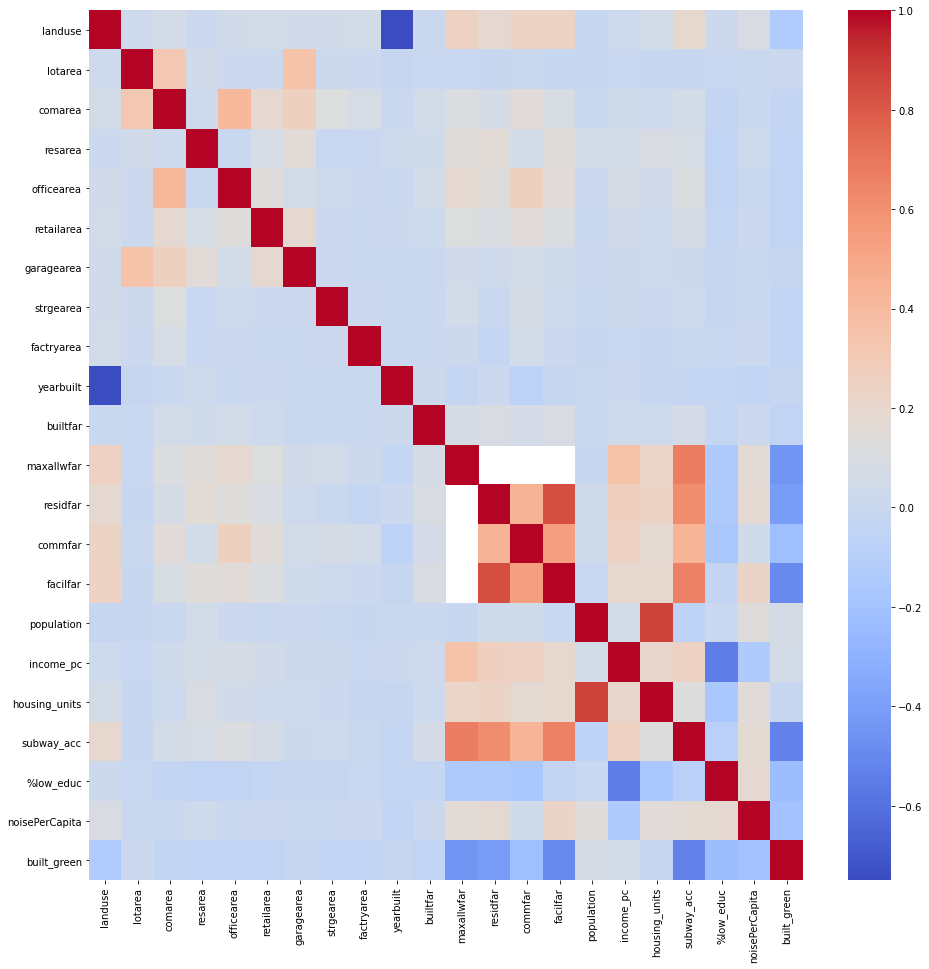

In [4]:
import seaborn
matrix_cols = data[['landuse', 
       'ownertype', 'lotarea', 'comarea', 'resarea', 'officearea',
       'retailarea', 'garagearea', 'strgearea', 'factryarea', 'yearbuilt',
       'builtfar', 'maxallwfar', 'residfar', 'commfar', 'facilfar', 'population',
       'income_pc', 'housing_units', 'subway_acc',
       '%low_educ', 'noisePerCapita','built_green'
       ]]
plt.figure(figsize=(16,16))
seaborn.heatmap(matrix_cols.corr(), annot=False, cmap='coolwarm')

Text(0.5, 1.0, 'Correlation between features')

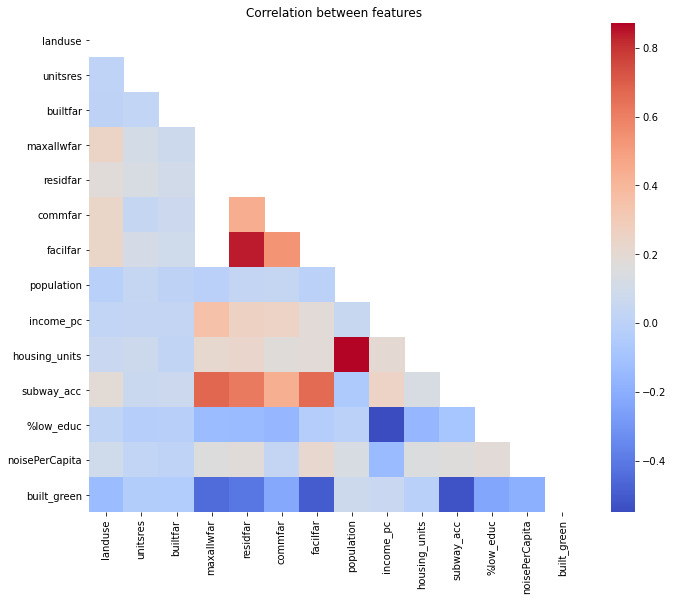

In [5]:
corr_cols = data[['landuse', 
       'ownertype', 'unitsres',
       'builtfar', 'maxallwfar', 'residfar', 'commfar', 'facilfar', 
       'population','income_pc', 'housing_units', 'subway_acc',
       '%low_educ', 'noisePerCapita','built_green'
       ]]
corr = corr_cols.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.rcParams['figure.figsize'] = [11, 9]
seaborn.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', fmt='.2f')
plt.title(label= "Correlation between features", fontdict=None, loc='center', pad=None)

In [6]:
#landuse vs. subway_acc
#subway_acc vs. income_pc / noisePerCapita
#far vs. income_pc / subway_acc / noisePerCapita / built_green

In [7]:
data['landuse'] = data['landuse'].replace([1,2,3,4,5,6,7,8,9,10,11],
                                          ['One & Two Family Buildings',
                                           'Multi-Family Walk-Up Buildings',
                                           'Multi-Family Elevator Buildings',
                                           'Mixed Residential & Commercial Buildings',
                                          'Commercial & Office Buildings',
                                          'Industrial & Manufacturing',
                                          'Transportation & Utility',
                                          'Public Facilities & Institutions',
                                          'Open Space & Outdoor Recreation',
                                          'Parking Facilities',
                                          'Vacant Land'])
data['landuse']

0                 Transportation & Utility
1                 Transportation & Utility
2               Industrial & Manufacturing
3                                      NaN
4                 Transportation & Utility
                        ...               
6946827    Open Space & Outdoor Recreation
6946828                        Vacant Land
6946829    Open Space & Outdoor Recreation
6946830           Transportation & Utility
6946831                        Vacant Land
Name: landuse, Length: 6946832, dtype: object

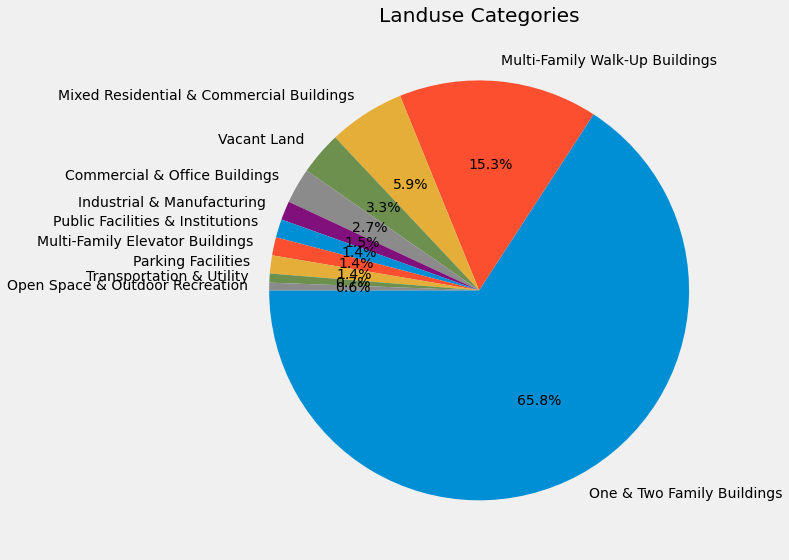

In [8]:
#01 One & Two Family Buildings
#02 Multi-Family Walk-Up Buildings
#03 Multi-Family Elevator Buildings
#04 Mixed Residential & Commercial Buildings
#05 Commercial & Office Buildings
#06 Industrial & Manufacturing
#07 Transportation & Utility
#08 Public Facilities & Institutions
#09 Open Space & Outdoor Recreation
#10 Parking Facilities
#11 Vacant Land
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9,9))
plt.title("Landuse Categories")
g = plt.pie(data.landuse.value_counts(), labels=data.landuse.value_counts().index,autopct='%1.1f%%', startangle=180)
plt.show()

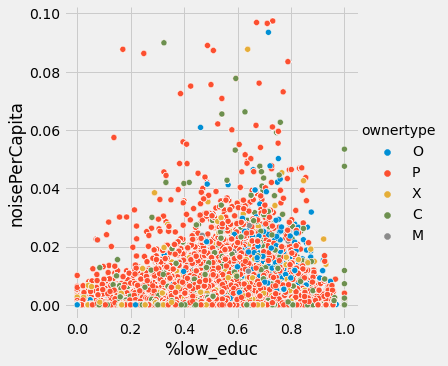

In [9]:
# %low_educ vs. noisePerCapita

#C City ownership
#M Mixed city & private ownership
#O Other – owned by either a public authority or the state or federal government
#P Private ownership
#X Fully tax-exempt property that may be owned by the city, state, or federal government; a public authority; or a private institution

seaborn.relplot(x='%low_educ', y='noisePerCapita', hue='ownertype', data=data[data.noisePerCapita<0.10])

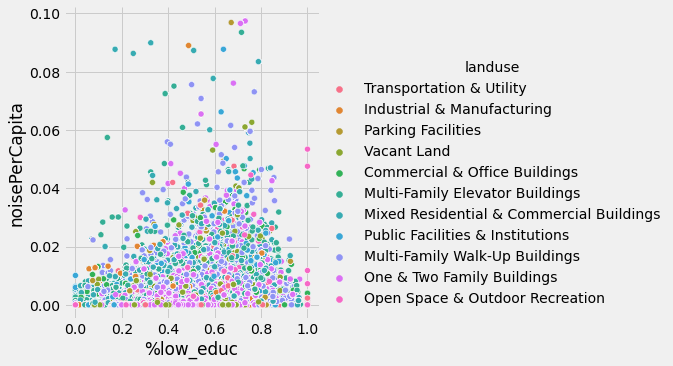

In [10]:
seaborn.relplot(x='%low_educ', y='noisePerCapita', hue='landuse', data=data[data.noisePerCapita<0.10])

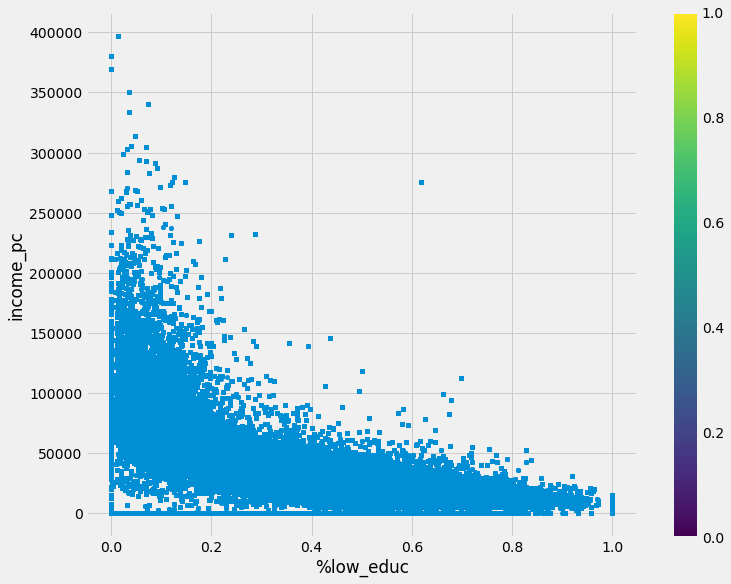

In [13]:
#"Education vs. Income"

ax=data.plot(kind='scatter', x='%low_educ', y='income_pc', cmap=plt.get_cmap('jet'), colorbar=True)
plt.show()

Text(0.5, 1.0, 'Landuse vs. %Education')

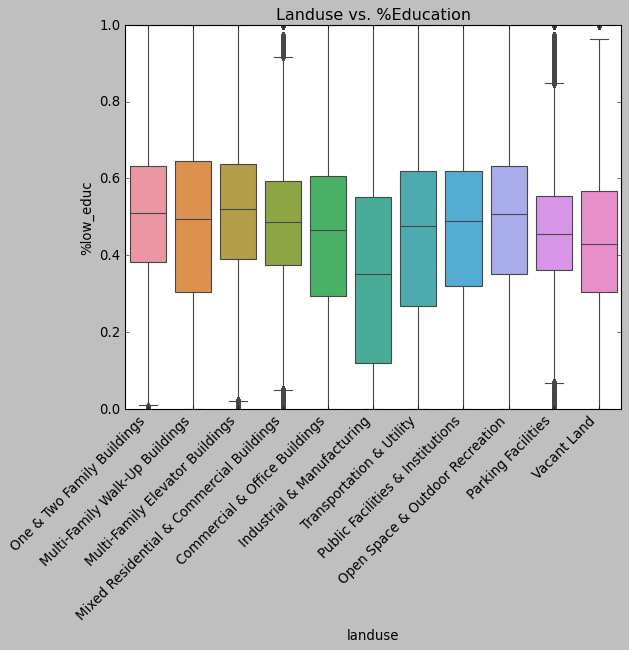

In [68]:
# Landuse vs. %Education
# 03 Multi-Family Elevator Buildings

graph=seaborn.boxplot(x='landuse', y='%low_educ', data= data)
                                    #aspect: increase the width of your graph 
graph.set_xticklabels(labels=['One & Two Family Buildings',
                                           'Multi-Family Walk-Up Buildings',
                                           'Multi-Family Elevator Buildings',
                                           'Mixed Residential & Commercial Buildings',
                                          'Commercial & Office Buildings',
                                          'Industrial & Manufacturing',
                                          'Transportation & Utility',
                                          'Public Facilities & Institutions',
                                          'Open Space & Outdoor Recreation',
                                          'Parking Facilities',
                                          'Vacant Land'], rotation=45, horizontalalignment='right')
                                    #rotation: the rotation of the vaues (House, Guesthouse,etc.)
plt.title("Landuse vs. %Education")

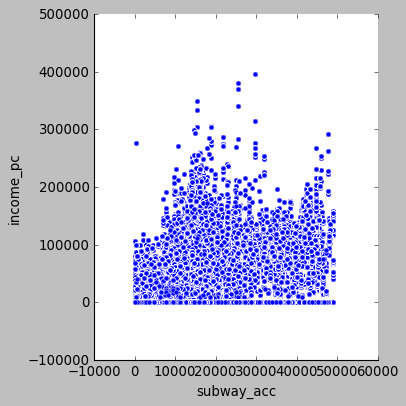

In [15]:
#subway_acc vs. income_pc
seaborn.relplot(x='subway_acc', y='income_pc', data=data[data.subway_acc>0])

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import  r2_score, mean_squared_error 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor

Text(0.5, 0.98, 'landuse vs. subway_acc')

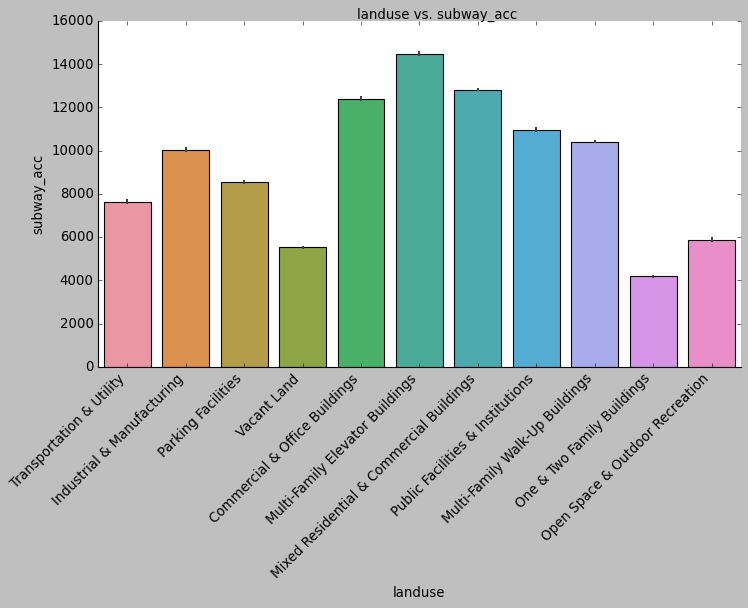

In [57]:
#01 One & Two Family Buildings
#02 Multi-Family Walk-Up Buildings
#03 Multi-Family Elevator Buildings
#04 Mixed Residential & Commercial Buildings
#05 Commercial & Office Buildings
#06 Industrial & Manufacturing
#07 Transportation & Utility
#08 Public Facilities & Institutions
#09 Open Space & Outdoor Recreation
#10 Parking Facilities
#11 Vacant Land
cpsl=seaborn.catplot(x='landuse', y='subway_acc', kind ='bar', data= data, aspect=2)
                                    #aspect: increase the width of your graph 
cpsl.set_xticklabels(rotation=45, horizontalalignment='right')
                                    #rotation: the rotation of the vaues (House, Guesthouse,etc.)
cpsl.fig.suptitle("landuse vs. subway_acc")

In [18]:
def fin_clean_data(df):    
    
    # drop irrelavent variables
    irrelavent_cols = ['yearbuilt', 'built_green']

    for col in  irrelavent_cols:
        # for each cat add dummy var, drop original column
        df = df.drop(col, axis=1)
    
    # Drop rows with missing salary values
    df = df.dropna(subset=['comarea'], axis=0)
    y = df['comarea']
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        

    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
    #    # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df.drop(['comarea'], axis=1)

    return X, y

In [19]:
#Use the above function to finalize the data preprocessing for X and y
X, y = fin_clean_data(matrix_cols)

In [20]:
#Splitting the training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state=42)
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [21]:
#Building the regressor and fit the dataset in
regressor = RandomForestRegressor(n_estimators=20, criterion='mse', random_state=42, n_jobs=-1)
                                    #n_estimators is the number of trees, change so that we can get better results 
                                    #No matter how many trees u build, the steps in the visulization will still be the same but the prediction is better   
                                    #random_state is the random number generator
regressor.fit(X_train, y_train.squeeze())

RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42)

In [22]:
#Model accuracties and validation analysis
y_train_preds = regressor.predict(X_train)
y_test_preds = regressor.predict(X_test)
print('RF Accuracies')
print('Random Forest MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_preds), mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_preds),r2_score(y_test, y_test_preds)))


RF Accuracies
Random Forest MSE train: 6512408.618, test: 653654890.159
Random Forest R^2 train: 0.998, test: 0.796


Text(0.5, 1.0, 'feature importances analysis for commercial area')

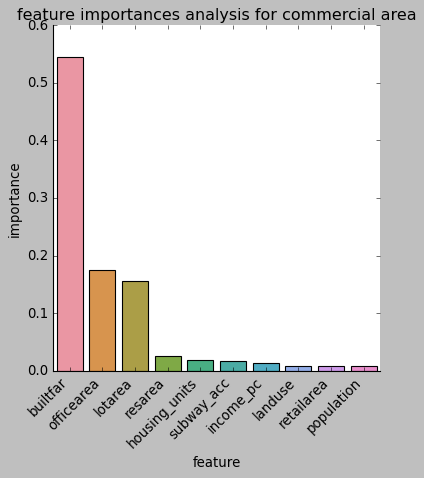

In [23]:
#Feature importancies ranking plot for commercial area
importances = regressor.feature_importances_
feat_names = X.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result_sort = tree_result.sort_values(by='importance',ascending=False)[:10]
chart = seaborn.catplot(x='feature', y='importance', kind='bar', data=tree_result_sort)
chart.set_xticklabels(rotation=45, horizontalalignment='right')
plt.title(label= "feature importances analysis for commercial area", fontdict=None, loc='center', pad=None)

In [24]:
def fin_clean_data1(df):    
    
    # drop irrelavent variables
    irrelavent_cols = ['yearbuilt', 'built_green']

    for col in  irrelavent_cols:
        # for each cat add dummy var, drop original column
        df = df.drop(col, axis=1)
    
    # Drop rows with missing salary values
    df = df.dropna(subset=['resarea'], axis=0)
    y = df['resarea']
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        

    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
    #    # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df.drop(['resarea'], axis=1)

    return X, y

In [25]:
X, y = fin_clean_data1(matrix_cols)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state=42)
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [27]:
regressor = RandomForestRegressor(n_estimators=20, criterion='mse', random_state=42, n_jobs=-1)
                                    #n_estimators is the number of trees, change so that we can get better results 
                                    #No matter how many trees u build, the steps in the visulization will still be the same but the prediction is better   
                                    #random_state is the random number generator
regressor.fit(X_train, y_train.squeeze())

RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42)

In [28]:
y_train_preds = regressor.predict(X_train)
y_test_preds = regressor.predict(X_test)
print('RF Accuracies')
print('Random Forest MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_preds), mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_preds),r2_score(y_test, y_test_preds)))

RF Accuracies
Random Forest MSE train: 4233952.012, test: 108326851.599
Random Forest R^2 train: 0.995, test: 0.882


Text(0.5, 1.0, 'feature importances analysis for commercial area')

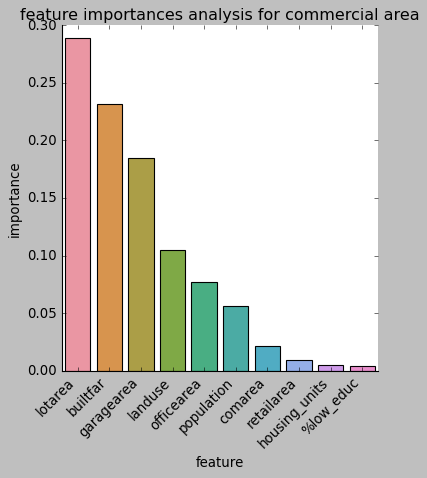

In [29]:
importances = regressor.feature_importances_
feat_names = X.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result_sort = tree_result.sort_values(by='importance',ascending=False)[:10]
chart = seaborn.catplot(x='feature', y='importance', kind='bar', data=tree_result_sort)
chart.set_xticklabels(rotation=45, horizontalalignment='right')
plt.title(label= "feature importances analysis for commercial area", fontdict=None, loc='center', pad=None)

In [30]:
data.borough.unique()

array(['BX', 'QN', 'BK', 'MN', 'SI'], dtype=object)

In [31]:
BK = data.loc[data['borough'] == 'BK']
BK

,Unnamed: 0,bbl,geoid,year_x,borough,lot,cd,zipcode,zonedist1,zonedist2,...,income_pc,housing_units,geometry,subway_acc,subway,subway_scale,%low_educ,noisePerCapita,tractid,built_green
89964,89964,3.005140e+09,360470053001,2010,BK,21,306,11231,M2-1,NaN,...,57733.0,150.0,POINT (-74.01701947529091 40.68059217001012),2031.234619,0.203944,0.203944,0.073913,0.000225,36047005300,0.144824
89965,89965,3.005140e+09,360470053001,2010,BK,21,306,11231,M2-1,NaN,...,57733.0,150.0,POINT (-74.01701947529091 40.68059217001012),2031.234619,0.203944,0.203944,0.073913,0.000225,36047005300,0.144824
89966,89966,3.005850e+09,360470053001,2010,BK,39,306,11231,M1-1,NaN,...,57733.0,150.0,POINT (-74.01559960054527 40.67752277249812),2031.234619,0.203944,0.203944,0.073913,0.000225,36047005300,0.144824
89967,89967,3.005850e+09,360470053001,2010,BK,39,306,11231,M1-1,NaN,...,57733.0,150.0,POINT (-74.01559960054527 40.67752277249812),2031.234619,0.203944,0.203944,0.073913,0.000225,36047005300,0.144824
89968,89968,3.005850e+09,360470053001,2010,BK,50,306,11231,M1-1,NaN,...,57733.0,150.0,POINT (-74.01620217269328 40.67793184116763),2031.234619,0.203944,0.203944,0.073913,0.000225,36047005300,0.144824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6451006,6451006,3.044158e+09,360471078004,2017,BK,7501,305,11207,R5,NaN,...,0.0,615.0,POINT (-73.88379027627037 40.6548012910399),4300.479004,0.242414,0.242414,0.426531,0.000000,36047107800,0.153137
6451007,6451007,3.002450e+09,360610009002,2017,BK,15,302,11201,M2-1,NaN,...,0.0,0.0,POINT (-74.00055426584839 40.69484981980336),-9999.000000,0.000000,0.000000,NaN,0.000000,36061000900,0.022110
6451008,6451008,3.002450e+09,360610009002,2017,BK,15,302,11201,M2-1,NaN,...,0.0,0.0,POINT (-74.00055426584839 40.69484981980336),-9999.000000,0.000000,0.000000,NaN,0.000000,36061000900,0.022110
6451009,6451009,3.002450e+09,360610005002,2017,BK,29,302,11201,M2-1,NaN,...,0.0,0.0,POINT (-74.00191719973945 40.69295827961557),-9999.000000,0.000000,0.000000,NaN,0.000000,36061000500,0.407292


In [32]:
BK_cols = BK[['landuse', 
       'ownertype', 'unitsres',
       'builtfar', 'maxallwfar', 'residfar', 'commfar', 'facilfar', 
       'population','income_pc', 'housing_units', 'subway_acc',
       '%low_educ', 'noisePerCapita','built_green'
       ]]
BK_cols

,landuse,ownertype,unitsres,builtfar,maxallwfar,residfar,commfar,facilfar,population,income_pc,housing_units,subway_acc,%low_educ,noisePerCapita,built_green
89964,Transportation & Utility,P,0,0.07,2.0,NaN,NaN,NaN,230.0,57733.0,150.0,2031.234619,0.073913,0.000225,0.144824
89965,Transportation & Utility,P,0,0.07,2.0,NaN,NaN,NaN,230.0,57733.0,150.0,2031.234619,0.073913,0.000225,0.144824
89966,Multi-Family Walk-Up Buildings,P,6,2.20,1.0,NaN,NaN,NaN,230.0,57733.0,150.0,2031.234619,0.073913,0.000225,0.144824
89967,Multi-Family Walk-Up Buildings,P,6,2.20,1.0,NaN,NaN,NaN,230.0,57733.0,150.0,2031.234619,0.073913,0.000225,0.144824
89968,One & Two Family Buildings,NaN,1,0.75,1.0,NaN,NaN,NaN,230.0,57733.0,150.0,2031.234619,0.073913,0.000225,0.144824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6451006,Mixed Residential & Commercial Buildings,NaN,550,0.46,NaN,1.25,0.0,2.0,980.0,0.0,615.0,4300.479004,0.426531,0.000000,0.153137
6451007,Transportation & Utility,M,0,0.34,NaN,0.00,2.0,0.0,0.0,0.0,0.0,-9999.000000,NaN,0.000000,0.022110
6451008,Transportation & Utility,M,0,0.34,NaN,0.00,2.0,0.0,0.0,0.0,0.0,-9999.000000,NaN,0.000000,0.022110
6451009,Transportation & Utility,C,0,0.60,NaN,0.00,2.0,0.0,0.0,0.0,0.0,-9999.000000,NaN,0.000000,0.407292


In [33]:
def fin_clean_data2(df):    
    
    # drop irrelavent variables
    irrelavent_cols = ['builtfar', 'maxallwfar', 'commfar', 'facilfar']
    
    for col in  irrelavent_cols:
        # for each cat add dummy var, drop original column
        df = df.drop(col, axis=1)
    
    # Drop rows with missing values
    df = df.dropna(subset=['residfar', 'landuse', 'ownertype', '%low_educ'], axis=0)
    #df = df.fillna(0)
    y = df['residfar']
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        

    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
    #    # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df.drop(['residfar'], axis=1)

    return X, y

In [34]:
X, y = fin_clean_data2(BK_cols)

In [35]:
y.unique()

array([ 2.  ,  2.43,  3.  ,  0.  ,  4.  ,  7.2 ,  2.7 ,  5.4 ,  9.  ,
        6.02,  3.44,  1.25,  6.  ,  1.65, 10.  ,  1.35,  0.9 ,  3.45,
        0.6 ,  0.5 ,  5.  ,  4.2 ,  7.52,  1.02])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state=42)
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [37]:
regressor = RandomForestRegressor(n_estimators=20, criterion='mse', random_state=42, n_jobs=-1)
                                    #n_estimators is the number of trees, change so that we can get better results 
                                    #No matter how many trees u build, the steps in the visulization will still be the same but the prediction is better   
                                    #random_state is the random number generator
regressor.fit(X_train, y_train.squeeze())

RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42)

In [38]:
y_train_preds = regressor.predict(X_train)
y_test_preds = regressor.predict(X_test)
print('RF Accuracies')
print('Random Forest MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_preds), mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_preds),r2_score(y_test, y_test_preds)))

RF Accuracies
Random Forest MSE train: 0.171, test: 0.385
Random Forest R^2 train: 0.889, test: 0.758


Text(0.5, 1.0, 'feature importances analysis for resdential far in BK')

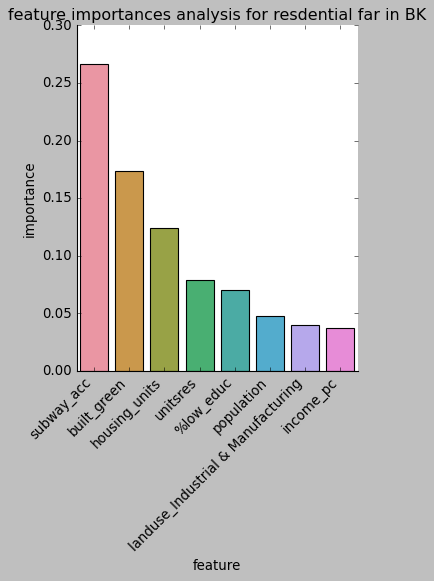

In [39]:
importances = regressor.feature_importances_
feat_names = X.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result_sort = tree_result.sort_values(by='importance',ascending=False)[:8]
chart = seaborn.catplot(x='feature', y='importance', kind='bar', data=tree_result_sort)
chart.set_xticklabels(rotation=45, horizontalalignment='right')
plt.title(label= "feature importances analysis for resdential far in BK", fontdict=None, loc='center', pad=None)

In [40]:
MN = data.loc[data['borough'] == 'MN']
MN_cols = MN[['landuse', 
       'ownertype', 'unitsres',
       'builtfar', 'maxallwfar', 'residfar', 'commfar', 'facilfar', 
       'population','income_pc', 'housing_units', 'subway_acc',
       '%low_educ', 'noisePerCapita','built_green'
       ]]
MN_cols

,landuse,ownertype,unitsres,builtfar,maxallwfar,residfar,commfar,facilfar,population,income_pc,housing_units,subway_acc,%low_educ,noisePerCapita,built_green
373303,Open Space & Outdoor Recreation,C,0,0.00,0.0,NaN,NaN,NaN,436.0,83862.0,589.0,30787.302734,0.052752,0.000501,0.022110
373304,Industrial & Manufacturing,NaN,0,5.52,15.0,NaN,NaN,NaN,436.0,83862.0,589.0,30787.302734,0.052752,0.000501,0.022110
373305,Commercial & Office Buildings,P,0,7.05,15.0,NaN,NaN,NaN,436.0,83862.0,589.0,30787.302734,0.052752,0.000501,0.022110
373306,Mixed Residential & Commercial Buildings,NaN,39,0.18,15.0,NaN,NaN,NaN,436.0,83862.0,589.0,30787.302734,0.052752,0.000501,0.022110
373307,Commercial & Office Buildings,NaN,2,4.01,15.0,NaN,NaN,NaN,436.0,83862.0,589.0,30787.302734,0.052752,0.000501,0.022110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6493757,Vacant Land,C,0,0.00,NaN,6.02,2.0,6.5,1795.0,0.0,1233.0,46853.386719,0.056825,0.000000,0.269999
6493758,Commercial & Office Buildings,P,0,1.47,NaN,6.02,2.0,6.5,1795.0,0.0,1233.0,46853.386719,0.056825,0.000000,0.269999
6493759,Public Facilities & Institutions,P,1904,5.60,NaN,6.02,2.0,6.5,1795.0,0.0,1233.0,46853.386719,0.056825,0.000000,0.269999
6493760,Vacant Land,C,0,0.00,NaN,6.02,2.0,6.5,1795.0,0.0,1233.0,46853.386719,0.056825,0.000000,0.269999


In [41]:
X, y = fin_clean_data2(MN_cols)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state=42)
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [43]:
regressor = RandomForestRegressor(n_estimators=20, criterion='mse', random_state=42, n_jobs=-1)
                                    #n_estimators is the number of trees, change so that we can get better results 
                                    #No matter how many trees u build, the steps in the visulization will still be the same but the prediction is better   
                                    #random_state is the random number generator
regressor.fit(X_train, y_train.squeeze())

RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42)

In [44]:
y_train_preds = regressor.predict(X_train)
y_test_preds = regressor.predict(X_test)
print('RF Accuracies')
print('Random Forest MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_preds), mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_preds),r2_score(y_test, y_test_preds)))

RF Accuracies
Random Forest MSE train: 0.858, test: 2.397
Random Forest R^2 train: 0.879, test: 0.665


Text(0.5, 1.0, 'feature importances analysis for resdential far in MN')

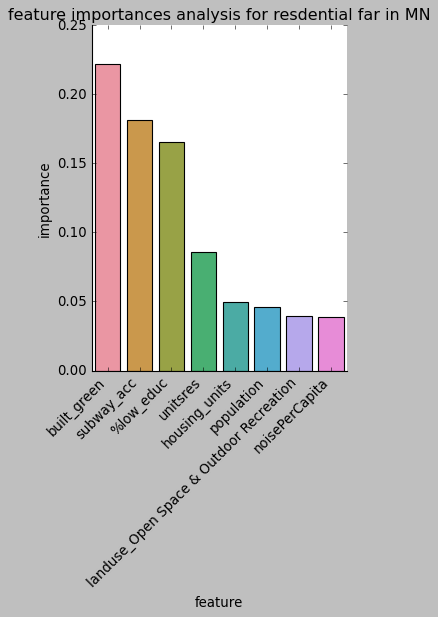

In [45]:
importances = regressor.feature_importances_
feat_names = X.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result_sort = tree_result.sort_values(by='importance',ascending=False)[:8]
chart = seaborn.catplot(x='feature', y='importance', kind='bar', data=tree_result_sort)
chart.set_xticklabels(rotation=45, horizontalalignment='right')
plt.title(label= "feature importances analysis for resdential far in MN", fontdict=None, loc='center', pad=None)

In [46]:
def fin_clean_data3(df):    
    
    # drop irrelavent variables
    irrelavent_cols = ['residfar', 'builtfar', 'maxallwfar', 'facilfar']
    
    for col in  irrelavent_cols:
        # for each cat add dummy var, drop original column
        df = df.drop(col, axis=1)
    
    # Drop rows with missing values
    df = df.dropna(subset=['commfar', 'landuse', 'ownertype', '%low_educ'], axis=0)
    #df = df.fillna(0)
    y = df['commfar']
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        

    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
    #    # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df.drop(['commfar'], axis=1)

    return X, y

In [47]:
X, y = fin_clean_data3(BK_cols)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state=42)
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [49]:
regressor = RandomForestRegressor(n_estimators=20, criterion='mse', random_state=42, n_jobs=-1)
                                    #n_estimators is the number of trees, change so that we can get better results 
                                    #No matter how many trees u build, the steps in the visulization will still be the same but the prediction is better   
                                    #random_state is the random number generator
regressor.fit(X_train, y_train.squeeze())

RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42)

In [50]:
y_train_preds = regressor.predict(X_train)
y_test_preds = regressor.predict(X_test)
print('RF Accuracies')
print('Random Forest MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_preds), mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_preds),r2_score(y_test, y_test_preds)))

RF Accuracies
Random Forest MSE train: 0.132, test: 0.293
Random Forest R^2 train: 0.888, test: 0.773


Text(0.5, 1.0, 'feature importances analysis for commercial far in BK')

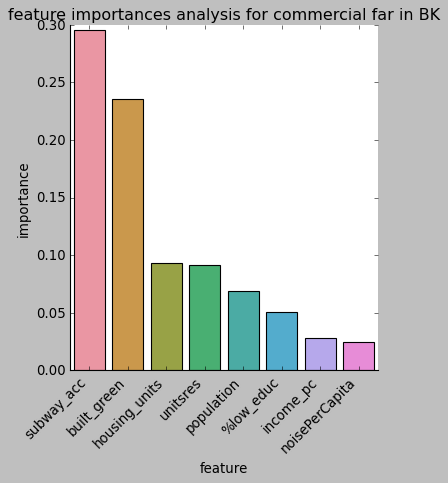

In [51]:
importances = regressor.feature_importances_
feat_names = X.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result_sort = tree_result.sort_values(by='importance',ascending=False)[:8]
chart = seaborn.catplot(x='feature', y='importance', kind='bar', data=tree_result_sort)
chart.set_xticklabels(rotation=45, horizontalalignment='right')
plt.title(label= "feature importances analysis for commercial far in BK", fontdict=None, loc='center', pad=None)

In [52]:
X, y = fin_clean_data3(MN_cols)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state=42)
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [54]:
regressor = RandomForestRegressor(n_estimators=20, criterion='mse', random_state=42, n_jobs=-1)
                                    #n_estimators is the number of trees, change so that we can get better results 
                                    #No matter how many trees u build, the steps in the visulization will still be the same but the prediction is better   
                                    #random_state is the random number generator
regressor.fit(X_train, y_train.squeeze())

RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42)

In [55]:
y_train_preds = regressor.predict(X_train)
y_test_preds = regressor.predict(X_test)
print('RF Accuracies')
print('Random Forest MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_preds), mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_preds),r2_score(y_test, y_test_preds)))

RF Accuracies
Random Forest MSE train: 0.608, test: 1.945
Random Forest R^2 train: 0.956, test: 0.860


Text(0.5, 1.0, 'feature importances analysis for commercial far in MN')

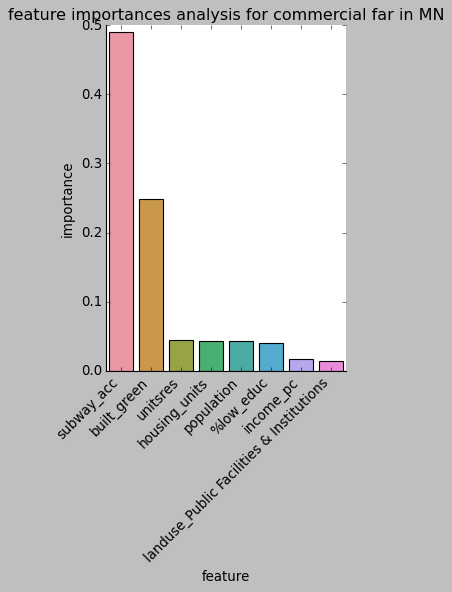

In [56]:
importances = regressor.feature_importances_
feat_names = X.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result_sort = tree_result.sort_values(by='importance',ascending=False)[:8]
chart = seaborn.catplot(x='feature', y='importance', kind='bar', data=tree_result_sort)
chart.set_xticklabels(rotation=45, horizontalalignment='right')
plt.title(label= "feature importances analysis for commercial far in MN", fontdict=None, loc='center', pad=None)